# Решение задачи регрессии точек с использованием модели fast_rcnn_R_50_FPN_1x и обучением по нескольким примерам

В ноутбуке проверяется подход к решению задачи регрессии ключевых точек с помощью построения модели регрессии на feature map предобученной модели

* получаем feature map с помощью модели fast_rcnn_R_50_FPN_1x
* тренируем модели линейной регрессии решать задачу k-points

Использованы картинки из датасета https://www.kaggle.com/datasets/crawford/cat-dataset

In [1]:
import json
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.modeling import build_model
from detectron2.structures import ImageList
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from sklearn.linear_model import LinearRegression, Ridge

import detectron2
from detectron2 import model_zoo

setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml")
cfg.MODEL.DEVICE = "cpu"

In [3]:
model = build_model(cfg)
model.eval()

checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

{'__author__': 'Detectron2 Model Zoo'}

In [4]:
cat_names = [
    "cats/00000001_000.jpeg",
    "cats/00000001_005.jpeg",
    "cats/00000001_008.jpeg",
    "cats/00000001_011.jpeg",
    "cats/00000001_017.jpeg",
    "cats/00000001_012.jpeg",
    "cats/00000001_020.jpeg",
    "cats/00000001_024.jpeg",
]
cat_target = [
    [175, 160, 239, 162, 199, 199, 149, 121, 137, 78, 166, 93, 281, 101, 312, 96, 296, 133],
    [96, 96, 153, 127, 103, 146, 48, 20, 78, -37, 127, 5, 210, 52, 260, 63, 229, 121],
    [318, 222, 340, 224, 327, 238, 301, 199, 304, 182, 321, 196, 341, 197, 359, 183, 361, 203],
    [167, 173, 242, 185, 191, 247, 112, 105, 118, 0, 171, 74, 270, 90, 353, 35, 332, 147],
    [410, 464, 511, 344, 568, 494, 222, 473, 113, 370, 288, 359, 380, 250, 337, 75, 476, 200],
    [115, 122, 179, 121, 133, 169, 95, 70, 93, 17, 131, 46, 233, 39, 281, 9, 224, 69],
    [225, 125, 337, 139, 250, 200, 186, 93, 169, 12, 237, 60, 360, 79, 462, 51, 411, 124],
    [278, 121, 347, 121, 317, 179, 228, 79, 220, 12, 282, 61, 339, 60, 397, 16, 387, 76],
]
cat_target = np.array(cat_target)

На 5 первых картинках будем обучаться, на 3 последних смотреть результат

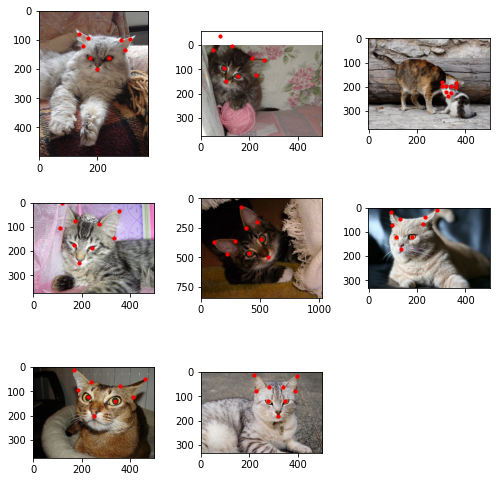

In [5]:
plt.figure(figsize=(7, 7), facecolor="w")
for i in range(len(cat_target)):
    plt.subplot(3, 3, i + 1)
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(cat_target[i][::2], cat_target[i][1::2], s=10, c="red")
plt.tight_layout()
plt.show()

Для обучения будем брать центральный вектор из feature map + еще 8 ближайших векторов. Пробовали брать не центральный, а вектор из середины k-points - это лик, но особого улучшения не дал

Для каждого из 9 векторов target будет немного отличаться (k-points вычисляются осносительно центра выбранного вектора)

In [16]:
with torch.no_grad():
    features_train = []
    features_test = []
    inputs = []
    target_train = []
    for i in range(len(cat_target)):
        im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
        height, width = im.shape[:2]
        image = torch.as_tensor(im.astype("float32").transpose(2, 0, 1))

        inp = [{"image": image, "height": height, "width": width}]
        inputs.append(inp[0])

        images = model.preprocess_image(inp)
        feature = model.backbone(images.tensor)["p6"]

        feature_map_size = 64
        x_target = cat_target[i][::2]
        y_target = cat_target[i][1::2]
        # середина feature map
        x = round(np.ceil(width / feature_map_size) / 2)
        y = round(np.ceil(height / feature_map_size) / 2)

        if i < 5:
            for x_ in range(x - 1, x + 2):
                for y_ in range(y - 1, y + 2):
                    features_train.append(np.array(feature[0, :, y_ - 1, x_ - 1]))
                    x_center = feature_map_size * (x_ + 0.5)
                    y_center = feature_map_size * (y_ + 0.5)
                    target_train.append(
                        np.hstack([(x_target - x_center) / feature_map_size, (y_target - y_center) / feature_map_size])
                    )

        features_test.append(np.array(feature[0, :, y - 1, x - 1]))

/home/asciishell/project/venv/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


Некоторые (близкие) вектора feature map действительно сильно коррелируют между собой

(256, 3, 3)


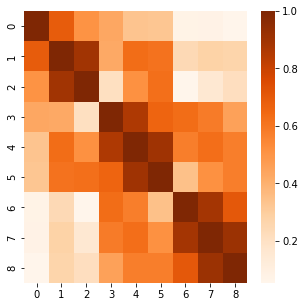

In [17]:
f = model.backbone(images.tensor)["p6"][0, :, y - 1 : y + 2, x - 1 : x + 2].detach().numpy()
print(f.shape)
f = f.reshape((256, -1))
f = np.abs(pd.DataFrame(f).corr())
plt.figure(figsize=(5, 5), facecolor="w")
sns.heatmap(f, cmap=plt.cm.Oranges);

In [18]:
np.array(features_train).shape, np.array(target_train).shape

((45, 256), (45, 18))

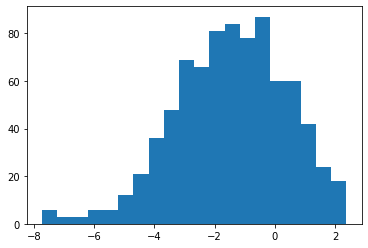

In [19]:
plt.hist(np.array(target_train).ravel(), bins=20);

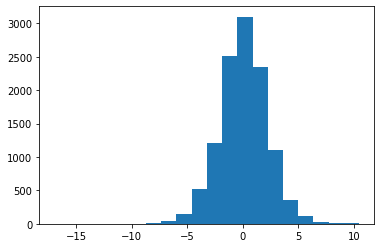

In [20]:
plt.hist(np.array(features_train).ravel(), bins=20);

In [21]:
regr = LinearRegression().fit(features_train, target_train)

In [22]:
regr.coef_.shape

(18, 256)

In [23]:
def predict(X):
    prediction = []
    output = regr.predict(X)

    for i in range(len(output)):
        h = inputs[i]["height"]
        w = inputs[i]["width"]
        x_output = output[i][:9] * feature_map_size
        y_output = output[i][9:] * feature_map_size
        x_output += (np.round(np.ceil(w / feature_map_size) / 2) + 0.5) * feature_map_size
        y_output += (np.round(np.ceil(h / feature_map_size) / 2) + 0.5) * feature_map_size
        prediction.append(np.hstack([x_output, y_output]))

    return prediction

In [24]:
prediction = predict(features_test)

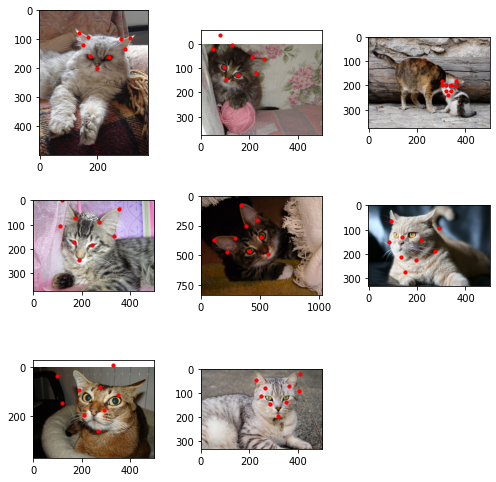

In [25]:
plt.figure(figsize=(7, 7), facecolor="w")
for i in range(len(cat_target)):
    plt.subplot(3, 3, i + 1)
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(prediction[i][:9], prediction[i][9:], s=10, c="red")
plt.tight_layout()
plt.show()